In [1]:
import pdb
import subject_data as sd
import os
import random
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt

import numpy as np

import cv2

import glob

from scipy.io import loadmat

import random

from random import seed, randint

from sklearn.model_selection import train_test_split

import pandas as pd

2023-05-08 22:52:37.361683: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
num_classes = 85
num_features = 100*100*40

# Training parameters. Sunday, May 24, 2020 
learning_rate = 0.001 # start with 0.001
training_steps = 50000
batch_size = 16
display_step = 50

sam = None

In [5]:
im_size = (100,100)
def get_subject_training_data(beg, tot):

    sub1_data, sub1_ppg = sd.get_sub1_data(beg, tot)
    sub2_data, sub2_ppg = sd.get_sub2_data(beg, tot)
    sub3_data, sub3_ppg = sd.get_sub3_data(beg, tot)
    sub4_data, sub4_ppg = sd.get_sub4_data(beg, tot)
    sub5_data, sub5_ppg = sd.get_sub5_data(beg, tot)
    sub6_data, sub6_ppg = sd.get_sub6_data(beg, tot)
    sub7_data, sub7_ppg = sd.get_sub7_data(beg, tot)

    # print('Sub 1:', sub1_data.shape)
    # print('Sub 2:', sub2_data.shape)
    # print('Sub 3:', sub3_data.shape)
    # print('Sub 4:', sub4_data.shape)
    # print('Sub 5:', sub5_data.shape)
    # print('Sub 6:', sub6_data.shape)
    # print('Sub 7:', sub7_data.shape)


    frame_cons = 40 # how many frame to consider at a time
    random.seed(1)
    rv = np.arange(0, tot - frame_cons, 1)
    np.random.shuffle(rv)

    def gen_pulR(ppg):
        return np.reshape(ppg, [ppg.shape[0],1])

    rv =  np.array(rv)
    pulR1 = gen_pulR(sub1_ppg)
    pulR2 = gen_pulR(sub2_ppg)
    pulR3 = gen_pulR(sub3_ppg)
    pulR4 = gen_pulR(sub4_ppg)
    pulR5 = gen_pulR(sub5_ppg)
    pulR6 = gen_pulR(sub6_ppg)
    pulR7 = gen_pulR(sub7_ppg)

    trainX = {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: []}
    trainY = {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: []}

    sub1_data = sub1_data[:,:,:,np.newaxis]
    sub2_data = sub2_data[:,:,:,np.newaxis]
    sub3_data = sub3_data[:,:,:,np.newaxis]
    sub4_data = sub4_data[:,:,:,np.newaxis]
    sub5_data = sub5_data[:,:,:,np.newaxis]
    sub6_data = sub6_data[:,:,:,np.newaxis]
    sub7_data = sub7_data[:,:,:,np.newaxis]

    def im_get(data, i):
        img = data[i:i+frame_cons,:,:,0]
        if img.shape[0] < frame_cons:
            return None
        img = np.reshape(img, [frame_cons, *im_size])
        img = np.moveaxis(img, 0,-1)
        return img

    for j, i in enumerate(rv):
        
        img1 = im_get(sub1_data, i)
        img2 = im_get(sub2_data, i)
        img3 = im_get(sub3_data, i)
        img4 = im_get(sub4_data, i)
        img5 = im_get(sub5_data, i)
        img6 = im_get(sub6_data, i)
        img7 = im_get(sub7_data, i)

        if img1 is None or img2 is None or img3 is None or img4 is None or img5 is None or img6 is None or img7 is None:
            continue

        trainX[1].append(img1)
        trainX[2].append(img2)
        trainX[3].append(img3)
        trainX[4].append(img4)
        trainX[5].append(img5)
        trainX[6].append(img6)
        trainX[7].append(img7)
        
        p_point = np.int(np.round(i*64/30))
        
        ppg = pulR1[p_point: p_point+85, 0]
        trainY[1].append(ppg)
        ppg = pulR2[p_point: p_point+85, 0]
        trainY[2].append(ppg)
        ppg = pulR3[p_point: p_point+85, 0]
        trainY[3].append(ppg)
        ppg = pulR4[p_point: p_point+85, 0]
        trainY[4].append(ppg)
        ppg = pulR5[p_point: p_point+85, 0]
        trainY[5].append(ppg)
        ppg = pulR6[p_point: p_point+85, 0]
        trainY[6].append(ppg)
        ppg = pulR7[p_point: p_point+85, 0]
        trainY[7].append(ppg)

    to_delete = []
    for key in trainX:
        try:
            trainX[key] = np.array(trainX[key], dtype = np.float32)
            trainX[key] = (trainX[key]-trainX[key].min())
            trainX[key] = trainX[key]/ trainX[key].max()
            
            trainY[key] = np.array(trainY[key], dtype = np.float32)
            trainY[key] = trainY[key] - trainY[key].min(axis = 1)[:, np.newaxis]
            trainY[key] = (trainY[key]/(trainY[key].max(axis = 1)[:, np.newaxis]+ 10**-5))*2-1
        except:
            print(f'Beg: {beg}, Tot: {tot}: had to delete subject {key}')
            to_delete.append(key)
    for key in to_delete:
        del trainX[key]
        del trainY[key]


    training_data = []
    testing_data = []
    for key in trainX:

        trX, teX, trY, teY = train_test_split(trainX[key], trainY[key], 
                                            test_size = .1, random_state = 42)

        train_data = tf.data.Dataset.from_tensor_slices((trX, trY))
        train_data = train_data.repeat().shuffle(buffer_size=100,
                                                seed= 8).batch(batch_size).prefetch(1)        
        test_data = tf.data.Dataset.from_tensor_slices((teX, teY))
        test_data = test_data.repeat().shuffle(buffer_size=100,
                                                seed= 8).batch(batch_size).prefetch(1)

        training_data.append(train_data)
        testing_data.append(test_data)

    return training_data, testing_data


# training_data, testing_data = get_subject_training_data(100, 100)

In [8]:
def RootMeanSquareLoss(x,y):
    
    # pdb.set_trace()  
    loss = tf.keras.losses.MSE(y_true = y, y_pred =x)  # initial one
    #return tf.reduce_mean(loss)  # some other shape similarity
     
    loss2 = tf.reduce_mean((tf.math.abs(tf.math.sign(y))-tf.math.sign(tf.math.multiply(x,y))),axis = -1)
    # print(loss2.shape)
    
    # print(tf.reduce_mean(loss), tf.reduce_mean(loss2))
    return loss + 0.5*loss2

In [9]:
#%%  Optimizer Definition
optimizer  = tf.optimizers.SGD(learning_rate)
optimizer1 = tf.optimizers.SGD(learning_rate/2)
    
def run_optimization(neural_net, x,y):    # for the second network varies in head
    with tf.GradientTape() as g:
        pred =  neural_net(x, training = True) 
        loss =  RootMeanSquareLoss(y, pred)  # change for mtl
        
    
    trainable_variables =  neural_net.trainable_variables
    # trainable_variables =  neural_net.trainable_variables[:-6] 
    # also there are other ways to update the gradient it would give the same results
    # trainable_var is a list, select your intended layers: use append  
    gradients =  g.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))


train_loss = []
val_loss = []

            
def Val_loss (neural_net, testX, testY):
    pred = neural_net(testX, training = False)
    loss = RootMeanSquareLoss(testY, pred)
    val_loss.append(tf.reduce_mean(loss))
    

def train_personalized_network(subject, total_iterations, total_frames, batch_scale):
    
    mtl_body =  MtlNetwork_body()
    head1 =  MtlNetwork_head(num_classes)
    head2 = MtlNetwork_head(num_classes)

    neural_net1 =  tf.keras.Sequential([mtl_body, head1])
    neural_net2 =  tf.keras.Sequential([mtl_body, head2])

    min_val_loss = float('inf')

    all_test_data = []

    batch_iterations = total_iterations // batch_scale
    batch_frames = total_frames // batch_scale
    curr_frame = 0

    for curr_frame in tqdm(range(0, total_frames, batch_frames)):

        print(f'Getting training data with {curr_frame}::{batch_frames}')
        training_data, testing_data = get_subject_training_data(curr_frame, batch_frames)
    
        for step in range(1, batch_iterations + 1):

            # Randomly select a subject's dataset
            subject_idx = random.randint(0, len(training_data) - 1)
            subject_data = training_data[subject_idx]
            
            batches = subject_data.take(1)
            batch_x, batch_y = next(iter(batches))
            run_optimization(neural_net1, batch_x, batch_y)
            
            if step % 10 == 0:
                
                pred = neural_net1(batch_x, training=True)
                loss = RootMeanSquareLoss(batch_y, pred)
                train_loss.append(tf.reduce_mean(loss))

                subject_idx = random.randint(0, len(training_data) - 1)
                subject_data = training_data[subject_idx]
                
                batches = subject_data.take(1)
                val_batch_x, val_batch_y = next(iter(batches))
                
                val_loss = RootMeanSquareLoss(val_batch_y, neural_net1(val_batch_x, training=False))
                current_val_loss = tf.reduce_mean(val_loss)
                
                print("step: %i, loss: %f val Loss: %f" % (step, tf.reduce_mean(loss), current_val_loss))
                
                # Save the model weights if the current validation loss is lower than the previous minimum validation loss
                if current_val_loss < min_val_loss:
                    min_val_loss = current_val_loss
                    if not os.path.exists("inprocess_weights"):
                        os.mkdir("inprocess_weights")
                    
                    print(f'Saving model with validation loss: {min_val_loss}\n')
                    neural_net1.save_weights("inprocess_weights/weights.hdf5")


In [15]:
from net_work_def import  MtlNetwork_head, MtlNetwork_body
from tqdm import tqdm


inarg = (neural_net1, neural_net2, 10000, 4000, 10)
with tf.device('gpu:0'):
    train_nn(*inarg)

Inside training method


  0%|          | 0/10 [00:00<?, ?it/s]

Getting training data with 0::400


/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:78: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


step: 10, loss: 0.956901 val Loss: 0.871422
Saving model with validation loss: 0.8714215159416199

step: 20, loss: 0.855279 val Loss: 0.879056
step: 30, loss: 0.815355 val Loss: 0.791315
Saving model with validation loss: 0.7913151979446411

step: 40, loss: 0.869657 val Loss: 0.847625
step: 50, loss: 0.796770 val Loss: 0.849015
step: 60, loss: 0.784066 val Loss: 0.815923
step: 70, loss: 0.834241 val Loss: 0.824086
step: 80, loss: 0.789926 val Loss: 0.806535
step: 90, loss: 0.796459 val Loss: 0.767980
Saving model with validation loss: 0.7679803967475891

step: 100, loss: 0.788778 val Loss: 0.843207
step: 110, loss: 0.748112 val Loss: 0.795335
step: 120, loss: 0.771752 val Loss: 0.864579
step: 130, loss: 0.743167 val Loss: 0.850383
step: 140, loss: 0.864587 val Loss: 0.829980
step: 150, loss: 0.852354 val Loss: 0.856755
step: 160, loss: 0.707406 val Loss: 0.808234
step: 170, loss: 0.795092 val Loss: 0.817448
step: 180, loss: 0.775083 val Loss: 0.861259
step: 190, loss: 0.700659 val Loss

 10%|█         | 1/10 [30:04<4:30:43, 1804.85s/it]

step: 1000, loss: 0.697008 val Loss: 0.716634
Getting training data with 400::400
step: 10, loss: 0.778309 val Loss: 0.811889
step: 20, loss: 0.770268 val Loss: 0.851973
step: 30, loss: 0.827612 val Loss: 0.870439
step: 40, loss: 0.815689 val Loss: 0.811155
step: 50, loss: 0.785880 val Loss: 0.803800
step: 60, loss: 0.835413 val Loss: 0.885653
step: 70, loss: 0.770573 val Loss: 0.843416
step: 80, loss: 0.840216 val Loss: 0.743350
step: 90, loss: 0.817029 val Loss: 0.830312
step: 100, loss: 0.732562 val Loss: 0.826386
step: 110, loss: 0.786631 val Loss: 0.880620
step: 120, loss: 0.812677 val Loss: 0.787134
step: 130, loss: 0.829506 val Loss: 0.782794
step: 140, loss: 0.756826 val Loss: 0.800622
step: 150, loss: 0.761351 val Loss: 0.770132
step: 160, loss: 0.802406 val Loss: 0.817325
step: 170, loss: 0.778757 val Loss: 0.731021
step: 180, loss: 0.775434 val Loss: 0.800990
step: 190, loss: 0.743327 val Loss: 0.777226
step: 200, loss: 0.783931 val Loss: 0.773557
step: 210, loss: 0.796580 v

 20%|██        | 2/10 [58:28<3:52:43, 1745.48s/it]

step: 1000, loss: 0.721329 val Loss: 0.794764
Getting training data with 800::400
step: 10, loss: 0.872109 val Loss: 0.972962
step: 20, loss: 0.849746 val Loss: 0.948393
step: 30, loss: 0.847925 val Loss: 0.694525
step: 40, loss: 0.750711 val Loss: 0.762052
step: 50, loss: 0.754146 val Loss: 0.782106
step: 60, loss: 0.790760 val Loss: 0.784395
step: 70, loss: 0.791028 val Loss: 0.700624
step: 80, loss: 0.825494 val Loss: 0.885221
step: 90, loss: 0.896102 val Loss: 0.971841
step: 100, loss: 0.729266 val Loss: 0.925317
step: 110, loss: 0.887841 val Loss: 0.777164
step: 120, loss: 0.893573 val Loss: 0.746729
step: 130, loss: 0.729066 val Loss: 0.755820
step: 140, loss: 0.721258 val Loss: 0.734308
step: 150, loss: 0.745047 val Loss: 0.705890
step: 160, loss: 0.707230 val Loss: 0.768937
step: 170, loss: 0.708559 val Loss: 0.747455
step: 180, loss: 0.762371 val Loss: 0.691682
step: 190, loss: 0.738254 val Loss: 0.759000
step: 200, loss: 0.823570 val Loss: 0.817455
step: 210, loss: 0.783606 v

 30%|███       | 3/10 [1:29:07<3:28:34, 1787.85s/it]

step: 1000, loss: 0.684699 val Loss: 0.764295
Getting training data with 1200::400
step: 10, loss: 0.742167 val Loss: 0.809553
step: 20, loss: 0.774205 val Loss: 0.878497
step: 30, loss: 0.712579 val Loss: 0.768780
step: 40, loss: 0.798582 val Loss: 0.830971
step: 50, loss: 0.742780 val Loss: 0.770971
step: 60, loss: 0.868610 val Loss: 0.846865
step: 70, loss: 0.714480 val Loss: 0.818819
step: 80, loss: 0.728852 val Loss: 0.799668
step: 90, loss: 0.711120 val Loss: 0.795744
step: 100, loss: 0.750475 val Loss: 0.799567
step: 110, loss: 0.825043 val Loss: 0.812828
step: 120, loss: 0.724145 val Loss: 0.845510
step: 130, loss: 0.781078 val Loss: 0.784741
step: 140, loss: 0.734313 val Loss: 0.805218
step: 150, loss: 0.696806 val Loss: 0.838583
step: 160, loss: 0.826470 val Loss: 0.723010
step: 170, loss: 0.806578 val Loss: 0.872586
step: 180, loss: 0.694263 val Loss: 0.831771
step: 190, loss: 0.712634 val Loss: 0.712292
step: 200, loss: 0.827754 val Loss: 0.698806
step: 210, loss: 0.687980 

 40%|████      | 4/10 [1:59:10<2:59:23, 1793.84s/it]

step: 1000, loss: 0.687173 val Loss: 0.739797
Getting training data with 1600::400
step: 10, loss: 0.810719 val Loss: 0.749048
step: 20, loss: 0.764147 val Loss: 0.782698
step: 30, loss: 0.835078 val Loss: 0.750365
step: 40, loss: 0.733047 val Loss: 0.840110
step: 50, loss: 0.789514 val Loss: 0.774526
step: 60, loss: 0.745046 val Loss: 0.803122
step: 70, loss: 0.723806 val Loss: 0.775176
step: 80, loss: 0.740822 val Loss: 0.768416
step: 90, loss: 0.748124 val Loss: 0.766354
step: 100, loss: 0.766883 val Loss: 0.774724
step: 110, loss: 0.761997 val Loss: 0.773707
step: 120, loss: 0.754785 val Loss: 0.749296
step: 130, loss: 0.692074 val Loss: 0.842081
step: 140, loss: 0.725354 val Loss: 0.737107
step: 150, loss: 0.776646 val Loss: 0.728583
step: 160, loss: 0.657084 val Loss: 0.846659
step: 170, loss: 0.711707 val Loss: 0.767472
step: 180, loss: 0.813081 val Loss: 0.798604
step: 190, loss: 0.784124 val Loss: 0.791548
step: 200, loss: 0.744725 val Loss: 0.757632
step: 210, loss: 0.692731 

 50%|█████     | 5/10 [3:39:51<4:37:07, 3325.59s/it]

step: 1000, loss: 0.750147 val Loss: 0.863358
Getting training data with 2000::400
step: 10, loss: 0.791912 val Loss: 0.748144
step: 20, loss: 0.672485 val Loss: 0.708949
step: 30, loss: 0.711257 val Loss: 0.773907
step: 40, loss: 0.672947 val Loss: 0.818716
step: 50, loss: 0.733522 val Loss: 0.778848
step: 60, loss: 0.686924 val Loss: 0.793162
step: 70, loss: 0.694646 val Loss: 0.705530
step: 80, loss: 0.714610 val Loss: 0.772158
step: 90, loss: 0.683668 val Loss: 0.753008
step: 100, loss: 0.728041 val Loss: 0.694032
step: 110, loss: 0.718392 val Loss: 0.688548
step: 120, loss: 0.738748 val Loss: 0.772345
step: 130, loss: 0.705626 val Loss: 0.843328
step: 140, loss: 0.662147 val Loss: 0.791342
step: 150, loss: 0.774551 val Loss: 0.707884
step: 160, loss: 0.659393 val Loss: 0.818584
step: 170, loss: 0.663413 val Loss: 0.684690
step: 180, loss: 0.712937 val Loss: 0.747690
step: 190, loss: 0.730165 val Loss: 0.713029
step: 200, loss: 0.713865 val Loss: 0.767701
step: 210, loss: 0.752905 

 60%|██████    | 6/10 [4:15:30<3:14:48, 2922.04s/it]

step: 1000, loss: 0.683341 val Loss: 0.818024
Getting training data with 2400::400
step: 10, loss: 0.724215 val Loss: 0.724483
step: 20, loss: 0.698595 val Loss: 0.772641
step: 30, loss: 0.706902 val Loss: 0.818941
step: 40, loss: 0.767263 val Loss: 0.810718
step: 50, loss: 0.707265 val Loss: 0.742599
step: 60, loss: 0.779208 val Loss: 0.835575
step: 70, loss: 0.769564 val Loss: 0.819721
step: 80, loss: 0.714361 val Loss: 0.891554
step: 90, loss: 0.659355 val Loss: 0.748619
step: 100, loss: 0.688989 val Loss: 0.715969
step: 110, loss: 0.740742 val Loss: 0.747583
step: 120, loss: 0.710780 val Loss: 0.762279
step: 130, loss: 0.690577 val Loss: 0.842059
step: 140, loss: 0.700741 val Loss: 0.770618
step: 150, loss: 0.691852 val Loss: 0.816493
step: 160, loss: 0.773196 val Loss: 0.814841
step: 170, loss: 0.705932 val Loss: 0.783927
step: 180, loss: 0.687646 val Loss: 0.727840
step: 190, loss: 0.680857 val Loss: 0.726550
step: 200, loss: 0.706527 val Loss: 0.719580
step: 210, loss: 0.678171 

 70%|███████   | 7/10 [4:37:48<2:00:12, 2404.25s/it]

step: 1000, loss: 0.589352 val Loss: 0.785032
Getting training data with 2800::400
step: 10, loss: 0.843853 val Loss: 0.754399
step: 20, loss: 0.781166 val Loss: 0.771615
step: 30, loss: 0.728955 val Loss: 0.843886
step: 40, loss: 0.743080 val Loss: 0.804551
step: 50, loss: 0.702577 val Loss: 0.896762
step: 60, loss: 0.793418 val Loss: 0.758036
step: 70, loss: 0.766384 val Loss: 0.766932
step: 80, loss: 0.803698 val Loss: 0.885374
step: 90, loss: 0.803494 val Loss: 0.736128
step: 100, loss: 0.733478 val Loss: 0.782131
step: 110, loss: 0.762363 val Loss: 0.780907
step: 120, loss: 0.764945 val Loss: 0.816083
step: 130, loss: 0.733638 val Loss: 0.792763
step: 140, loss: 0.755470 val Loss: 0.818206
step: 150, loss: 0.737324 val Loss: 0.752566
step: 160, loss: 0.742030 val Loss: 0.789836
step: 170, loss: 0.668762 val Loss: 0.776249
step: 180, loss: 0.752528 val Loss: 0.814740
step: 190, loss: 0.739577 val Loss: 0.744922
step: 200, loss: 0.734835 val Loss: 0.762737
step: 210, loss: 0.736446 

 80%|████████  | 8/10 [4:59:59<1:08:45, 2062.54s/it]

step: 1000, loss: 0.607749 val Loss: 0.822770
Getting training data with 3200::400
step: 10, loss: 0.750609 val Loss: 0.852421
step: 20, loss: 0.793175 val Loss: 0.803668
step: 30, loss: 0.759830 val Loss: 0.871476
step: 40, loss: 0.733067 val Loss: 0.713190
step: 50, loss: 0.731374 val Loss: 0.866747
step: 60, loss: 0.800103 val Loss: 0.831495
step: 70, loss: 0.650904 val Loss: 0.791233
step: 80, loss: 0.761343 val Loss: 0.817605
step: 90, loss: 0.733038 val Loss: 0.744119
step: 100, loss: 0.831697 val Loss: 0.831559
step: 110, loss: 0.743415 val Loss: 0.744502
step: 120, loss: 0.752039 val Loss: 0.721453
step: 130, loss: 0.673026 val Loss: 0.771065
step: 140, loss: 0.713864 val Loss: 0.773710
step: 150, loss: 0.707514 val Loss: 0.775355
step: 160, loss: 0.664572 val Loss: 0.773169
step: 170, loss: 0.721462 val Loss: 0.789647
step: 180, loss: 0.713954 val Loss: 0.782940
step: 190, loss: 0.740832 val Loss: 0.856640
step: 200, loss: 0.692019 val Loss: 0.806655
step: 210, loss: 0.709348 

 90%|█████████ | 9/10 [5:22:05<30:32, 1832.29s/it]  

step: 1000, loss: 0.617450 val Loss: 0.764746
Getting training data with 3600::400
step: 10, loss: 0.656152 val Loss: 0.883097
step: 20, loss: 0.743906 val Loss: 0.862780
step: 30, loss: 0.756640 val Loss: 0.786535
step: 40, loss: 0.632139 val Loss: 0.845282
step: 50, loss: 0.713680 val Loss: 0.735958
step: 60, loss: 0.689143 val Loss: 0.852700
step: 70, loss: 0.659485 val Loss: 0.691212
step: 80, loss: 0.677570 val Loss: 0.747928
step: 90, loss: 0.662941 val Loss: 0.899117
step: 100, loss: 0.702822 val Loss: 0.767613
step: 110, loss: 0.603788 val Loss: 0.763665
step: 120, loss: 0.713519 val Loss: 0.754435
step: 130, loss: 0.630175 val Loss: 0.837192
step: 140, loss: 0.601888 val Loss: 0.747273
step: 150, loss: 0.760125 val Loss: 0.742283
step: 160, loss: 0.583437 val Loss: 0.827453
step: 170, loss: 0.550085 val Loss: 0.723985
step: 180, loss: 0.700752 val Loss: 0.732164
step: 190, loss: 0.608864 val Loss: 0.751767
step: 200, loss: 0.646825 val Loss: 0.665186
step: 210, loss: 0.733665 

100%|██████████| 10/10 [5:44:11<00:00, 2065.16s/it]

step: 1000, loss: 0.623720 val Loss: 0.822873


In [20]:
import os
neural_net1.save_weights('./flight/flight')

In [21]:
sub1_data, sub1_ppg = sd.get_sub1_data(1000, 100)

/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


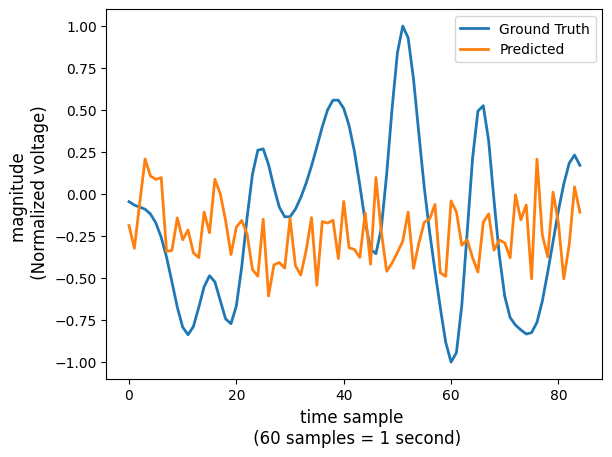

In [22]:
neural_net1.load_weights('inprocess_weights/weights.hdf5')

i = 0
tX = np.reshape(sub1_data[i: i + 40,:,:], [40,100,100])
tX = np.array(tX, dtype= np.float64)
tX = np.moveaxis(tX, 0,-1) # very important line in axis changeing 

p_point = np.int(np.round(i*64/30))
gt = sub1_ppg[p_point: p_point+85, 0]
gt = (gt-gt.min())/(gt.max()-gt.min())

tX1 = np.reshape(tX, [-1, 100,100,40])
plt.plot(gt*2-1)
tX1 = (tX1 - tX1.min())/(tX1.max() - tX1.min())
predd = neural_net1(tX1) 
plt.plot(predd[0])

plt.legend(["Ground Truth", "Predicted"])
plt.xlabel('time sample \n (60 samples = 1 second)', fontsize =12)
plt.ylabel('magnitude \n (Normalized voltage)', fontsize = 12)
from matplotlib import rcParams
rcParams['lines.linewidth'] = 2
rcParams['lines.color'] = 'r'
plt.show()